In [1]:
setwd('/nfs/lab/projects/islet_cytok/analysis/snATAC/coaccess')

In [11]:
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(RColorBrewer))

In [3]:
u = read.table("../../deseq_ATAC_NEW_bedfiles/annotated_peaks.tsv")

In [4]:
diff = gsub("peak-","", rownames(u))
diff = unique(gsub("-","_", diff))

In [5]:
bd = str_split_fixed (diff, "_", 3)

In [52]:
write.table(bd, 'all_diff_sites.bed', sep="\t", quote=F, col.names=F, row.names=F)

In [9]:
cells = c('untreated','cytokine', 'cyt_unt')

In [233]:
for (cell in cells){
file = paste0(cell,  '/5kb_all/promLabel/beta.cicero_conns_dedup.promLabelled.txt')
conns = fread(file, data.table = F)
coacc = subset(conns, coaccess >= 0.05)
write.table(coacc, paste0(cell, ".beta.coaccessible.peaks.tsv"), sep="\t", quote=F, col.names=T, row.names=F)
}

In [158]:
smry = data.frame()
for (cell in cells){
file = paste0(cell,  '/5kb_all/promLabel/beta.cicero_conns_dedup.promLabelled.txt')
conns = fread(file, data.table = F)
coacc = subset(conns, coaccess >= 0.05)
coacc$CC = coacc[,4] =="." & coacc[,5]=="."
coacc$CP = (coacc[,4]=="." & coacc[,5]!=".") | (coacc[,4]!="." & coacc[,5]==".")
coacc$PP = coacc[,4]!="." & coacc[,5]!="."
coacc$type = apply(coacc[,6:8], 1, function(x) paste(as.numeric(x), collapse=""))
coacc$type = c('PP', 'CP', 'CC') [as.numeric(as.factor(coacc$type))]

smry = rbind(smry, table(coacc$type))

p1 = str_split_fixed(coacc$Peak1, "_",3)
p2 = str_split_fixed(coacc$Peak2, "_",3)

bedpe = cbind(p1, p2, coacc$type, coacc$Peak1Promoter, coacc$Peak2Promoter)

write.table(bedpe, paste0(cell, ".beta.coacc.bedpe"), sep="\t", quote=F, col.names=F, row.names=F)
                   }

In [159]:
colnames(smry) =  c( 'CC', 'CP', 'PP')
rownames(smry) = cells

In [161]:
for(cell in cells){
system(paste('pgltools intersect1D -a', paste0(cell, ".beta.coacc.pgl") ,  
             '-b ../../ldsc/Islet_bulkATAC.bed -allA -wa -wb >',
       paste0(cell, ".beta.coacc.intersect.alsites")))
}

In [160]:
for(cell in cells){
system( paste( 'pgltools formatbedpe' , paste0(cell, ".beta.coacc.bedpe"), '>', paste0(cell, ".beta.coacc.pgl")))
system(paste('pgltools intersect1D -a', paste0(cell, ".beta.coacc.pgl") ,  '-b all_diff_sites.bed -allA -wa -wb >',
       paste0(cell, ".beta.coacc.intersect.differential")))
    }

In [162]:
smry2 = data.frame()
for (cell in cells){
file = paste0(cell,  '.beta.coacc.intersect.differential')
conns = fread(file, data.table = F)
conns = subset(conns, !duplicated(conns[,1:6]))
    smry2 = rbind(smry2, table(conns[,8]))
}

In [163]:
colnames(smry2) =   c( 'CC', 'CP', 'PP')
rownames(smry2) = cells

In [164]:
col3 = brewer.pal(3,'Blues')

In [166]:
smry3 = data.frame(peak=rownames(u))
for (cell in cells){
file = paste0(cell,  '.beta.coacc.intersect.differential')
conns = fread(file, data.table = F)
coacc = subset(conns, V8=="CP")
coacc$peak = paste('peak', coacc$V11,  coacc$V12,  coacc$V13, sep="-")
coacc$dist = coacc$V6 - coacc$V2
colnames(coacc)[9] = 'gene'
colnames(coacc)[10] = 'gene2'
coacc$distal = (coacc$gene=="." & coacc$V7=="A") | (coacc$gene2=="." & coacc$V7=="B")
coacc = subset(coacc, distal ==TRUE)
map  = coacc[,c('peak', 'dist', 'gene')]
map2 = coacc[,c('peak', 'dist', 'gene2')]
colnames(map2)[3] = c('gene')
map  = rbind(map, map2)
map  = map[!duplicated(map),]
map = subset(map, gene!=".")
map = map[map$dist>10000,]
smry3 [,cell]= (smry3$peak   %in% map$peak)
    }

In [193]:
intersec = read.table("../../enrichment_genes/genes_within_10kb", sep="\t")
cent1 = intersec[,2] + ((intersec[,3]-intersec[,2])/2) 
cent2 = intersec[,5] + ((intersec[,6]-intersec[,5])/2) 
dist = abs(cent1 - cent2)
intersec$peak = paste("peak",intersec$V1, intersec$V2,intersec$V3, sep="-")
int = intersec[,c(8, 7)]
colnames(int) = c("peak", "gene")
int$dist = dist

In [194]:
int = int[int$peak %in% rownames(u),]
int=int[int$dist<10000,]
int2=int[int$dist<2500,]

In [204]:
smry3 [,"prom"]= smry3$peak   %in% int2$peak

In [226]:
colSums(smry3[,2:5])

untreated  cytokine   cyt_unt      prom 
     8434     11124     11480      4428

In [210]:
toplot = colSums(smry3[,2:5])/nrow(smry3)

In [228]:
round(toplot,2)

untreated  cytokine   cyt_unt      prom 
     0.19      0.25      0.26      0.10

In [216]:
pdf("/nfs/lab/projects/islet_cytok/analysis/cytokine_figures/coaccessible_sites_beta_cytunt.pdf")
par(mfrow=c(2,2),mar = c(4,4,4,5))
barplot(as.matrix(t(smry/1000)), las=3, col=col3 , ylim=c(0,5e+02), ylab="# coacc. sites (x1e3)")
barplot(as.matrix(t(smry2/1000)), las=3, col=col3 , ylim=c(0,2.5e+02), ylab="# coacc. sites (x1e3) in DACs")
barplot(cbind(t(smry/1000),t(smry2/1000)), las=3, col=col3 ,  ylab="# coacc. sites (x1e3) ")
legend("topright", legend =  c( 'CC', 'CP', 'PP'), pch=22, pt.bg=col3, pt.cex=1.5)
barplot(toplot, ylab="fract. DACs with coacc.gene",col=col3[2], ylim=c(0,0.3), las=2)

dev.off()

png 
  2

In [199]:
table(smry3$cytokine, smry3$prom25)

       
        FALSE  TRUE
  FALSE 29421  4424
  TRUE  11120     4

In [200]:
table(smry3$cyt_unt, smry3$prom25)

       
        FALSE  TRUE
  FALSE 29063  4426
  TRUE  11478     2

In [219]:
smry2

,CC,CP,PP
,<int>,<int>,<int>
untreated,60988,40548,23888
cytokine,112693,58508,29927
cyt_unt,123978,59305,31398


In [225]:
smry$CC/rowSums(smry)

untreated  cytokine   cyt_unt 
0.3622854 0.4453363 0.4629093

In [223]:
smry

,CC,CP,PP
,<int>,<int>,<int>
untreated,100515,99958,76974
cytokine,178314,130222,91867
cyt_unt,204330,139098,97976


### Compare with HiChip data

In [10]:
suppressPackageStartupMessages(library(cicero))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(pheatmap))

In [3]:
setwd('/nfs/lab/projects/islet_cytok/analysis/snATAC/coaccess')

In [4]:
#unt_dir = '/nfs/lab/mokino/SP21/endoC_HiChIP/18may21_baseline_newpeaks/MAPS_output/A471_Arima_EndoB_Lo_S1_L002_current/'
#cyt_dir = '/nfs/lab/mokino/SP21/endoC_HiChIP/17may21_cyt_newpeaks/MAPS_output/A471_Arima_EndoC_Lo_S3_L002_current/'

In [5]:
unt_dir = cyt_dir = getwd()

In [6]:
#cyt = read.table(paste0(cyt_dir,'A471_Arima_EndoC_Lo_S3_L002.5k.2.sig3Dinteractions.bedpe'), header=T)
#unt = read.table(paste0(unt_dir,'A471_Arima_EndoB_Lo_S1_L002.5k.2.sig3Dinteractions.bedpe'), header=T)

cyt = read.table(paste0(cyt_dir,'/A471.EndoC_cyt.FDR10.bedpe'), header=T)
unt = read.table(paste0(unt_dir,'/A471.EndoC_unt.FDR10.bedpe'), header=T)

cyt = data.frame(Peak1 = paste(cyt[,1], cyt[,2], cyt[,3], sep="_"),
                 Peak2 = paste(cyt[,4], cyt[,5], cyt[,6], sep="_"))

unt = data.frame(Peak1 = paste(unt[,1], unt[,2], unt[,3], sep="_"),
                 Peak2 = paste(unt[,4], unt[,5], unt[,6], sep="_"))

cyt = cyt[!duplicated(cyt),]
unt = unt[!duplicated(unt),]

In [7]:
nrow(cyt)
nrow(unt)

[1] 27793

[1] 32560

In [8]:
cells = c('untreated','cytokine', 'cyt_unt')

In [13]:
m4=data.frame()
for (cell in cells){

file = paste0(cell,  '/5kb_all/promLabel/beta.cicero_conns_dedup.promLabelled.txt')
conns = fread(file, data.table = F)

conns$CC = conns[,4] =="." & conns[,5]=="."
conns$CP = (conns[,4]=="." & conns[,5]!=".") | (conns[,4]!="." & conns[,5]==".")
conns$PP = conns[,4]!="." & conns[,5]!="."
#conns = subset(conns, CP == TRUE)
    
coacc = subset(conns, coaccess >= 0.05)
    

cic = coacc[,1:3]

in_cyt  <- compare_connections(cyt, cic, maxgap=1000)
in_unt  <- compare_connections(unt, cic, maxgap=1000)

v4=c (sum(in_cyt)/ length(in_cyt), sum(in_unt)/ length(in_unt))
m4 = rbind(m4, v4) 
    
conns$in_hichip_cyt  <- compare_connections(conns[,1:3], cyt, maxgap=1000)
conns$in_hichip_unt  <- compare_connections(conns[,1:3], unt, maxgap=1000)
    
    
assign(cell, conns)        
    
    }

In [14]:
rownames(m4)= cells
colnames(m4)= c("%cyt_coacc", "%unt_coacc")

In [15]:
m4

,%cyt_coacc,%unt_coacc
,<dbl>,<dbl>
untreated,0.1762314,0.1786855
cytokine,0.2297341,0.2219902
cyt_unt,0.2338718,0.2297297


In [16]:
### all sites
filist

ERROR: Error in eval(expr, envir, enclos): object 'filist' not found


In [54]:
## only CP
filist

$CcytHcyt
       
          FALSE    TRUE
  FALSE 1655999   15727
  TRUE   127702    2520

$CuntHcyt
       
          FALSE    TRUE
  FALSE 1341262   14242
  TRUE    98066    1892

$CcytHunt
       
          FALSE    TRUE
  FALSE 1653902   17824
  TRUE   127549    2673

$CuntHunt
       
          FALSE    TRUE
  FALSE 1339023   16481
  TRUE    97895    2063


In [55]:
2520/ (127702+2520)

[1] 0.01935157

In [56]:
2063/(97895+2063)

[1] 0.02063867

In [17]:
filist= list(    CcytHcyt = table(cytokine$coaccess>0.05,cytokine$in_hichip_cyt==T ),
                 CuntHcyt = table(untreated$coaccess>0.05,untreated$in_hichip_cyt==T ),
                 CcytHunt = table(cytokine$coaccess>0.05,cytokine$in_hichip_unt==T ),
                 CuntHunt = table(untreated$coaccess>0.05,untreated$in_hichip_unt==T ))

In [19]:
lapply(filist, fisher.test)

$CcytHcyt

	Fisher's Exact Test for Count Data

data:  X[[i]]
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.492463 3.670254
sample estimates:
odds ratio 
  3.580428 


$CuntHcyt

	Fisher's Exact Test for Count Data

data:  X[[i]]
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.056553 3.238489
sample estimates:
odds ratio 
  3.146439 


$CcytHunt

	Fisher's Exact Test for Count Data

data:  X[[i]]
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.415344 3.580242
sample estimates:
odds ratio 
   3.49717 


$CuntHunt

	Fisher's Exact Test for Count Data

data:  X[[i]]
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.131235 3.302870
sample estimates:
odds ratio 
  3.216146 



In [50]:
fish_res = t(sapply(filist, function(x) unlist(fisher.test(x)[1:4])))

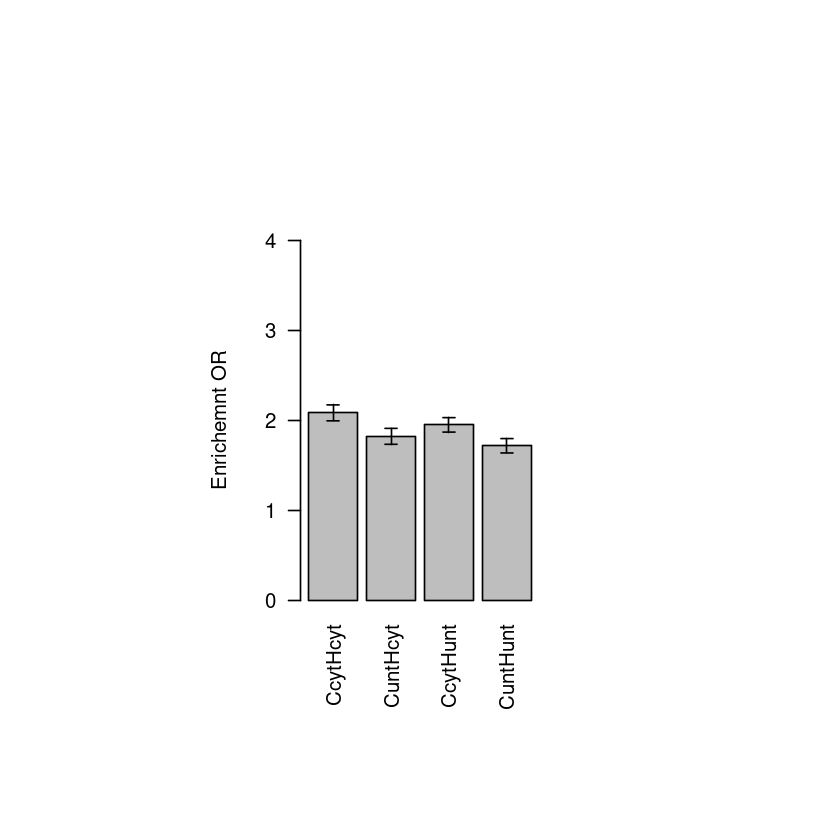

In [51]:
par(pin=c(2,3))
bp = barplot( fish_res[,4],  names = row.names(fish_res), las = 2, ylim= c(0, 4), ylab="Enrichemnt OR")
arrows( bp,fish_res[,2],bp,fish_res[,3], code=3, angle=90, length=0.05)


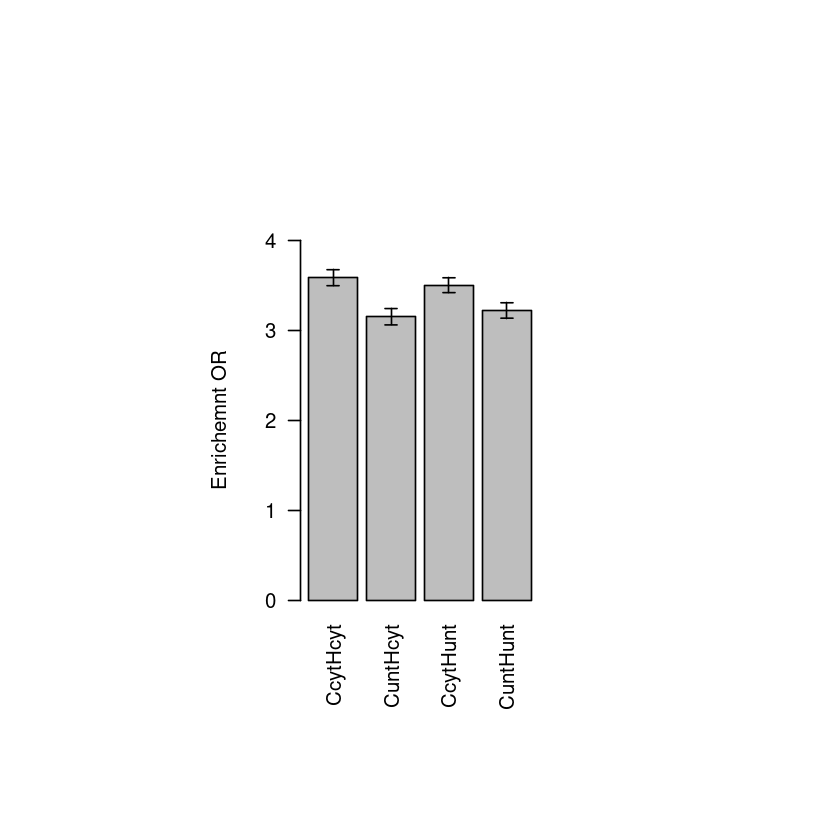

In [33]:
par(pin=c(2,3))
bp = barplot( fish_res[,4],  names = row.names(fish_res), las = 2, ylim= c(0, 4), ylab="Enrichemnt OR")
arrows( bp,fish_res[,2],bp,fish_res[,3], code=3, angle=90, length=0.05)
